In [1]:
import cv2
import numpy as np
from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.losses import * 
from tensorflow.keras.metrics import * 
from tensorflow.keras.losses import * 
import tensorflow as tf
from tensorflow.keras.callbacks import *
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
import warnings
import glob
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

2025-08-31 15:16:04.225464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756653364.413555      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756653364.466529      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def augmentations(img, mask):
    images = []
    masks = []

    # Original
    images.append(img)
    masks.append(mask)

    # Horizontal flip
    images.append(cv2.flip(img, 1))
    masks.append(cv2.flip(mask, 1))

    # Vertical flip
    images.append(cv2.flip(img, 0))
    masks.append(cv2.flip(mask, 0))

    # 90° rotation
    images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    masks.append(cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE))

    # 180° rotation
    images.append(cv2.rotate(img, cv2.ROTATE_180))
    masks.append(cv2.rotate(mask, cv2.ROTATE_180))

    # 270° rotation
    images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    masks.append(cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE))

    # Gaussian blur (only image, mask stays same)
    images.append(cv2.GaussianBlur(img, (5, 5), 0))
    masks.append(mask.copy())

    return images, masks

In [3]:
def load(path, aug=False):
    X, y = [], []

    files = [f for f in os.listdir(os.path.join(path, "Original"))]
    for f in tqdm(files):
        try:
            img = cv2.imread(os.path.join(path, "Original", f))
            mask = cv2.imread(os.path.join(path, "Ground truth", f))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

            if aug:
                images, masks = augmentations(img, mask)
            else:
                images, masks = [img], [mask]

            for im, m in zip(images, masks):
                im = cv2.resize(im, (128, 128)) / 255.
                X.append(im)

                m = cv2.resize(m, (128, 128)) // 255

                y.append(np.expand_dims(m, -1).astype(np.int8))

        except Exception as e:
            print(f"Skipping {f} due to error: {e}")


    return np.array(X), np.array(y)

In [4]:
X_train, y_train = load("/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train", True)
X_test, y_test = load("/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test", False)

 66%|██████▌   | 397/601 [01:24<00:42,  4.75it/s][ WARN:0@98.321] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train/Ground truth/Thumbs.db'): can't open/read file: check file path/integrity


Skipping Thumbs.db due to error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


In [5]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [6]:
print(f"NUMBER OF TRAIN SAMPLES : {X_train.shape[0]}\nNUMBER OF VALIDATION SAMPLES : {X_test.shape[0]}\nNUMBER OF TEST SAMPLES : {X_test.shape[0]}")

NUMBER OF TRAIN SAMPLES : 4200
NUMBER OF VALIDATION SAMPLES : 100
NUMBER OF TEST SAMPLES : 100


In [7]:
def conv_block(filters, kernel_size, x, dropout_rate=0., use_res=False):
    skip = x
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if dropout_rate > 0:
        x = SpatialDropout2D(dropout_rate)(x)  # better than Dropout for CNNs

    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if use_res:
        x = Add()([x, Conv2D(filters, 1, padding="same")(skip)])
    return x

In [8]:
INP = Input((128, 128, 3))

# ---------- ENCODER ----------
x_00 = conv_block(64, 3, INP)
x_10 = conv_block(128, 3, MaxPooling2D()(x_00))
x_20 = conv_block(256, 3, MaxPooling2D()(x_10))
x_30 = conv_block(512, 3, MaxPooling2D()(x_20))
x_40 = conv_block(1024, 3, MaxPooling2D()(x_30), 0.4)
# ---------- DECODER (Dense Skip Connections) ----------
# First column
x_01 = conv_block(64, 3, concatenate([x_00, UpSampling2D()(x_10)]))
x_11 = conv_block(128, 3, concatenate([x_10, UpSampling2D()(x_20)]))
x_21 = conv_block(256, 3, concatenate([x_20, UpSampling2D()(x_30)]))
x_31 = conv_block(512, 3, concatenate([x_30, UpSampling2D()(x_40)]))

# Second column
x_02 = conv_block(64, 3, concatenate([x_00, x_01, UpSampling2D()(x_11)]), 0.3)
x_12 = conv_block(128, 3, concatenate([x_10, x_11, UpSampling2D()(x_21)]), 0.3)
x_22 = conv_block(256, 3, concatenate([x_20, x_21, UpSampling2D()(x_31)]), 0.3)

# Third column
x_03 = conv_block(64, 3, concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 0.2)
x_13 = conv_block(128, 3, concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 0.2)

# Fourth column
x_04 = conv_block(64, 3, concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]))

# ---------- OUTPUT ----------
outputs = Conv2D(1, 1, activation="sigmoid")(x_04)

model = Model(inputs=INP, outputs=outputs)
model.summary()

I0000 00:00:1756653541.633178      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 36,644,225 (139.79 MB)

 Trainable params: 36,629,633 (139.73 MB)

 Non-trainable params: 14,592 (57.00 KB)

In [9]:
model.compile(optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5), loss="binary_crossentropy", metrics = ["accuracy", BinaryIoU(name="io_u")])
reducelr = ReduceLROnPlateau(
    monitor="val_io_u",
    factor=0.1,
    patience=3,
    mode="max",
    min_lr=1e-6,
)
checkpoint = ModelCheckpoint(
    "model.keras",
    monitor="val_io_u",
    save_best_only=True,
    mode="max",
)

In [10]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks = [reducelr, checkpoint])

Epoch 1/30


I0000 00:00:1756653577.327182      99 service.cc:148] XLA service 0x7c9b60003fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756653577.327957      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756653580.348342      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756653643.292589      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8983 - io_u: 0.4962 - loss: 0.2823

E0000 00:00:1756653745.265055      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756653745.510186      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756653747.079384      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756653747.337020      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756653749.698440      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

132/132 ━━━━━━━━━━━━━━━━━━━━ 208s 837ms/step - accuracy: 0.8986 - io_u: 0.4969 - loss: 0.2817 - val_accuracy: 0.9348 - val_io_u: 0.4674 - val_loss: 0.2309 - learning_rate: 0.0010
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 505ms/step - accuracy: 0.9696 - io_u: 0.7834 - loss: 0.0949 - val_accuracy: 0.9346 - val_io_u: 0.4697 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 504ms/step - accuracy: 0.9759 - io_u: 0.8271 - loss: 0.0715 - val_accuracy: 0.9327 - val_io_u: 0.5514 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9782 - io_u: 0.8432 - loss: 0.0637 - val_accuracy: 0.9474 - val_io_u: 0.6866 - val_loss: 0.1536 - learning_rate: 0.0010
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9794 - io_u: 0.8513 - loss: 0.0595 - val_accuracy: 0.9750 - val_io_u: 0.8176 - val_loss: 0.0711 - learning_rate: 0.0010
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy

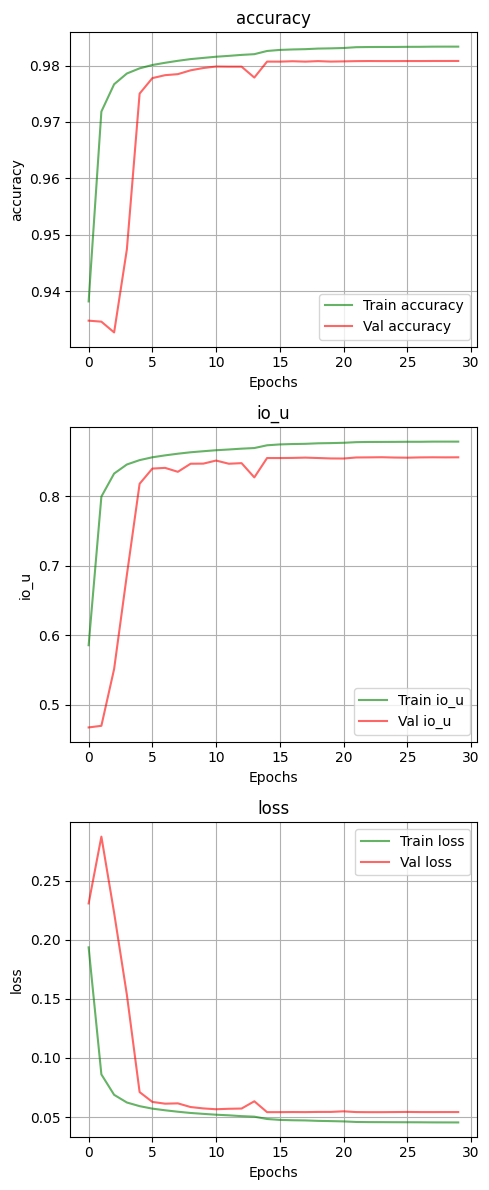

In [13]:
hist = history.history

metric_keys = [k for k in hist.keys()][:3]

n_metrics = len(metric_keys)
fig, axes = plt.subplots(n_metrics, 1, figsize=(5, 4*n_metrics))

if n_metrics == 1:
    axes = [axes]  # ensure axes is iterable for single metric

for ax, key in zip(axes, metric_keys):
    ax.plot(hist[key], label=f"Train {key}", color="green", alpha=0.6)
    val_key = f"val_{key}"
    if val_key in hist:
        ax.plot(hist[val_key], label=f"Val {key}", color="red", alpha=0.6)
    ax.set_title(key)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

In [14]:
model = load_model("model.keras")

In [16]:
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - accuracy: 0.9804 - io_u: 0.8510 - loss: 0.0556


[0.055174294859170914, 0.9805365204811096, 0.8519203662872314]

In [41]:
model_preds = model.predict(X_test)
binary_preds = (model_preds > 0.5).astype(np.uint8).squeeze(-1)

gt_masks = y_test
if gt_masks.ndim == 4 and gt_masks.shape[-1] == 1:
    gt_masks = np.squeeze(gt_masks, axis=-1)
gt_masks = gt_masks.astype(np.uint8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


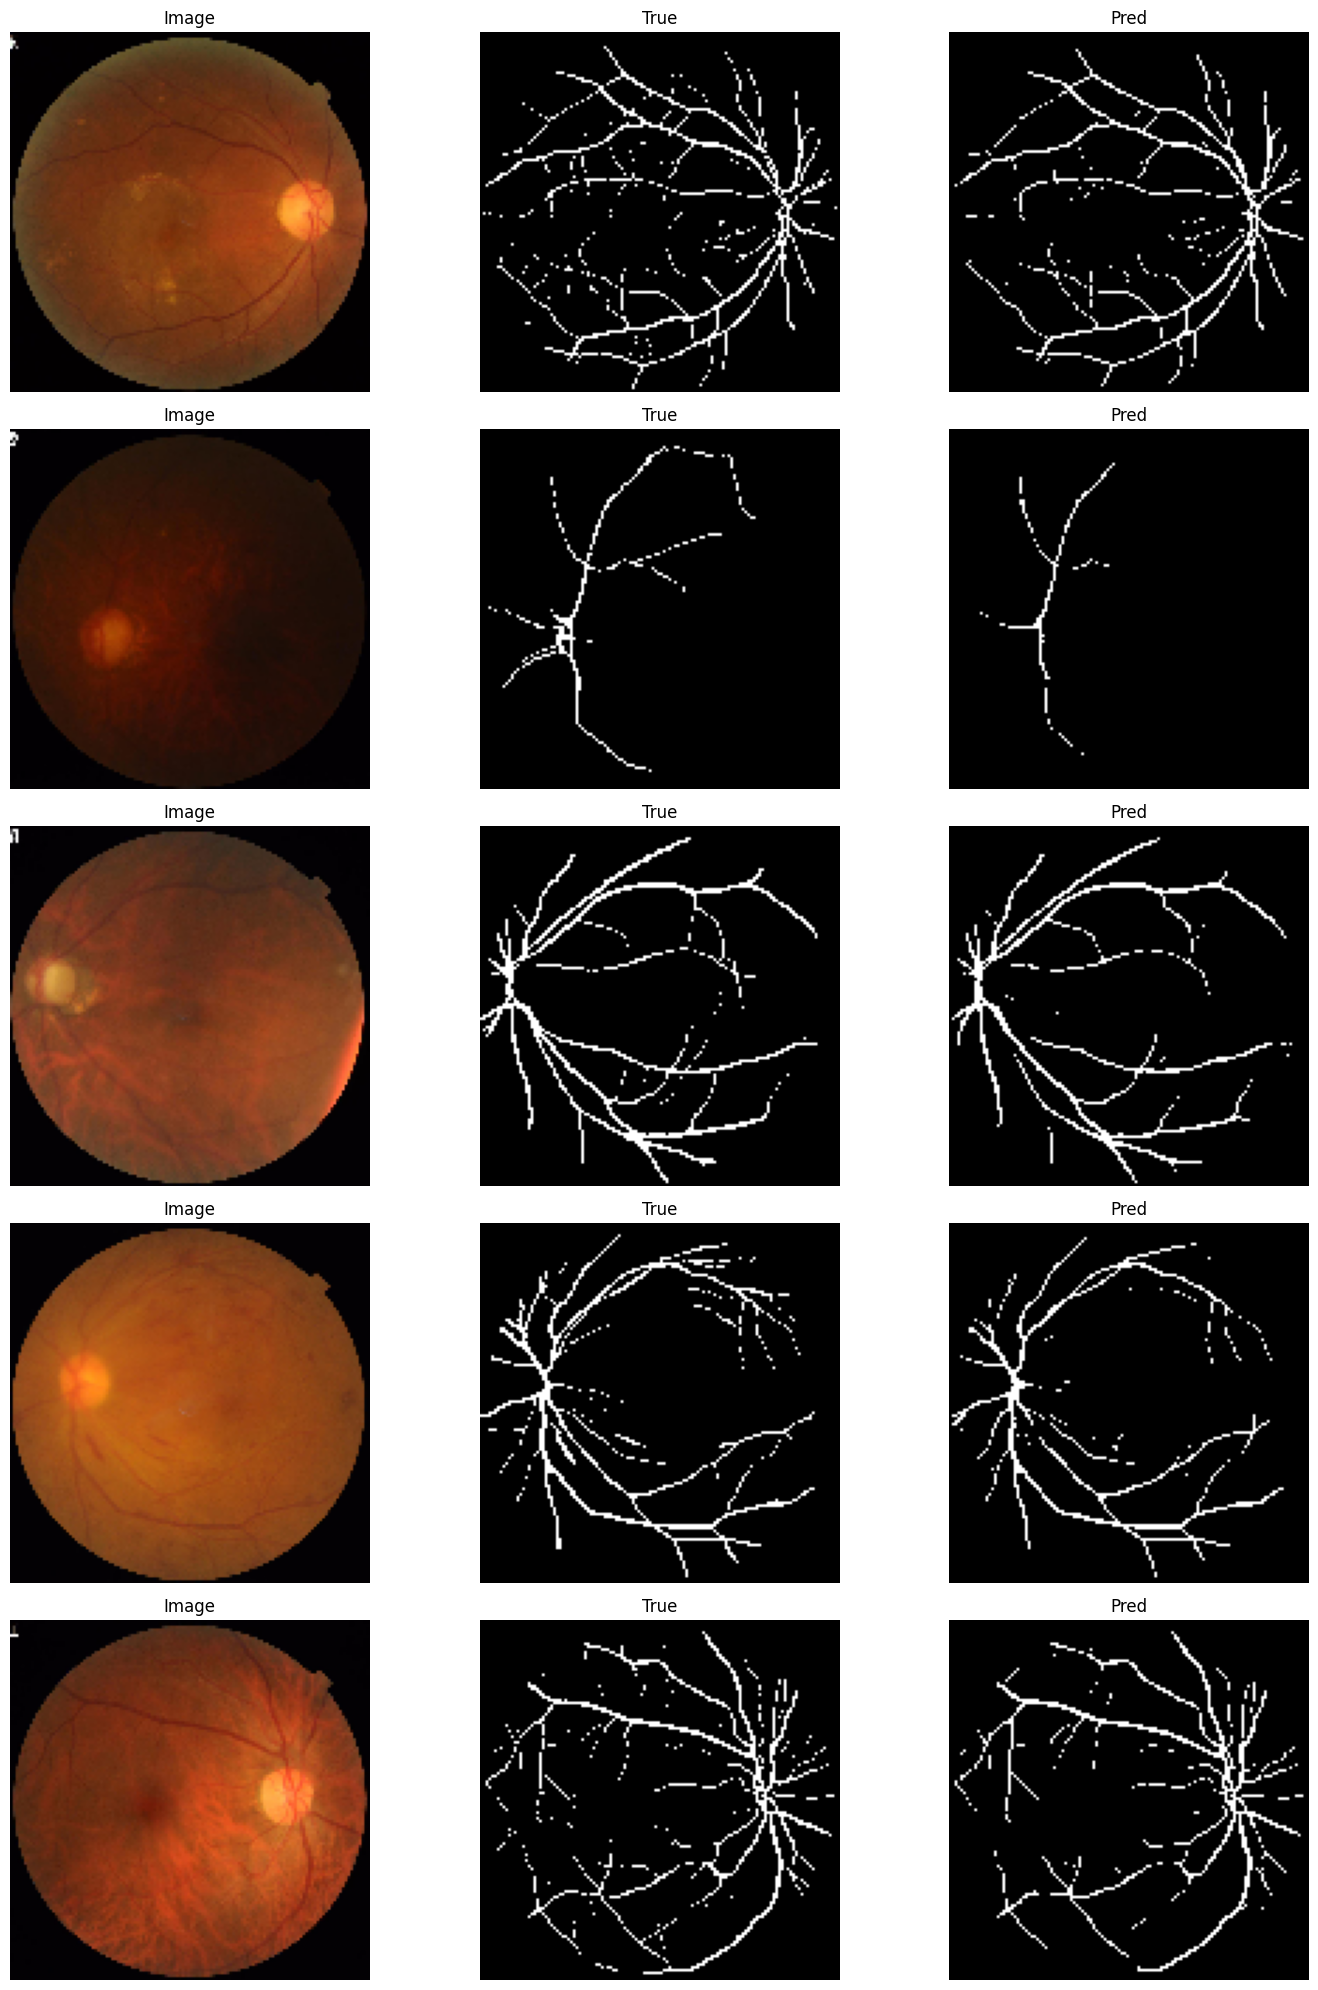

In [51]:
n_samples = 5 
cols = 3
rows = n_samples 

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

for i in range(n_samples):
    # original image
    axes[i, 0].imshow(cv2.cvtColor((X_test[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')
    
    # ground truth mask
    axes[i, 1].imshow(gt_masks[i], cmap='gray')
    axes[i, 1].set_title("True")
    axes[i, 1].axis('off')
    
    # predicted mask
    axes[i, 2].imshow(binary_preds[i], cmap='gray')
    axes[i, 2].set_title("Pred")
    axes[i, 2].axis('off')
plt.tight_layout()
plt.savefig(f'masks.png') 
plt.show()

In [61]:

pred_display_masks = np.zeros((binary_preds.shape[0], binary_preds.shape[1], binary_preds.shape[2], 3), dtype=np.uint8)
true_display_masks = np.zeros((gt_masks.shape[0], gt_masks.shape[1], gt_masks.shape[2], 3), dtype=np.uint8)

for i in range(binary_preds.shape[0]):
    pred_display_masks[i][binary_preds[i].astype(bool)] = (255, 0, 0)  
    true_display_masks[i][gt_masks[i].astype(bool)] = (255, 0, 0)      

def display(start, n_samples):
    cols = 4  
    rows = math.ceil((n_samples * 2) / cols)
    plt.figure(figsize=(cols*5, rows*4))
    
    for i, idx in enumerate( range(start, start+n_samples)):
        # True overlay
        plt.subplot(rows, cols, i*2 + 1)
        plt.imshow(cv2.cvtColor((X_test[idx] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB), cmap='gray')
        plt.imshow(true_display_masks[idx], alpha=0.5)
        plt.title("True")
        plt.axis('off')
    
        # Pred overlay
        plt.subplot(rows, cols, i*2 + 2)
        plt.imshow(cv2.cvtColor((X_test[idx] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB), cmap='gray')
        plt.imshow(pred_display_masks[idx], alpha=0.5)
        plt.title("Pred")
        plt.axis('off')
    plt.savefig(f'vessels-{start}.png', dpi=200) 
    plt.tight_layout()
    plt.show()

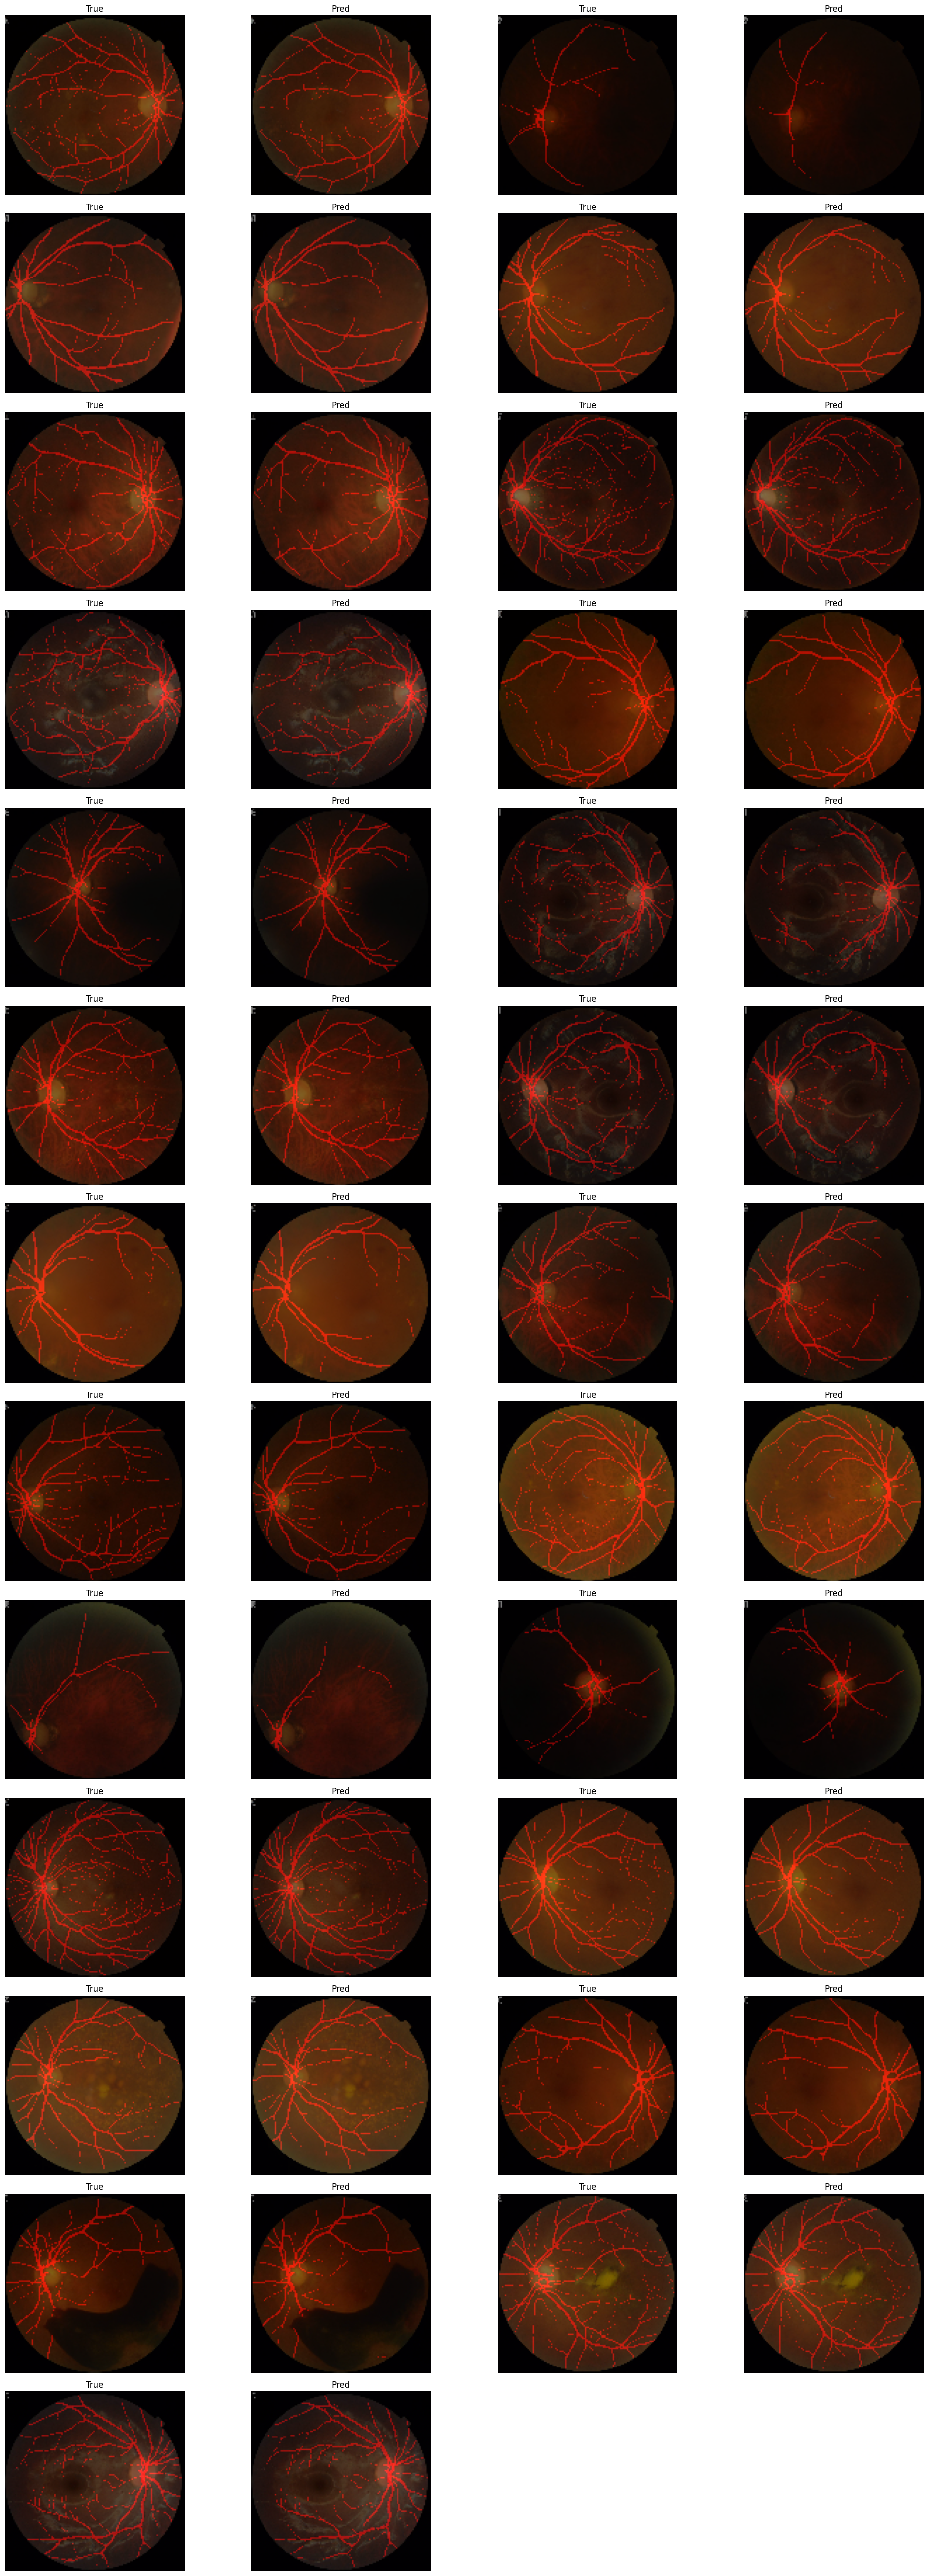

In [62]:
display(0, 25)

In [ ]:
display(25, 50)

In [ ]:
display(50, 75)

In [ ]:
display(75, 100)